<a href="https://colab.research.google.com/github/Souvik2biswas/Solar-cycle-prediction/blob/main/SUN1cycGBM26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-optimize

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Datasets/monthlySSA.csv')
data

,DATE,Area
0,1874-05-01,365.1
1,1874-06-01,415.2
2,1874-07-01,1033.5
3,1874-08-01,954.1
4,1874-09-01,335.3
...,...,...
1783,2022-12-01,1326.4
1784,2023-01-01,1846.2
1785,2023-02-01,1278.5
1786,2023-03-01,1013.2


In [ ]:
data['DATE']=pd.to_datetime(data['DATE'])
data=data.set_index('DATE')

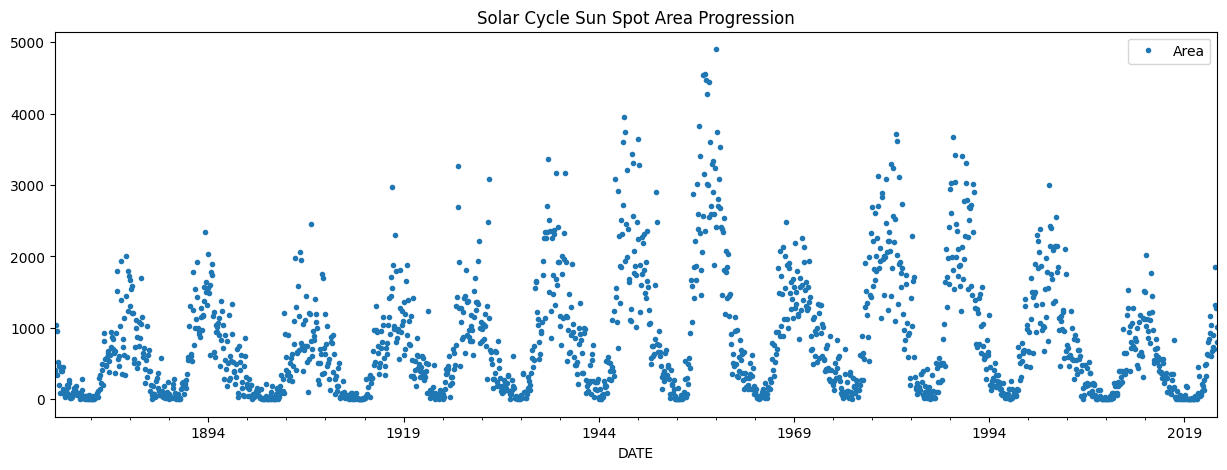

In [ ]:
data.plot(style='.',
        figsize=(15, 5),
        title='Solar Cycle Sun Spot Area Progression')
plt.show()

In [ ]:
data

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
2022-12-01,1326.4
2023-01-01,1846.2
2023-02-01,1278.5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1788 entries, 1874-05-01 to 2023-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    1788 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


<Axes: title={'center': 'Peaks'}, xlabel='DATE'>

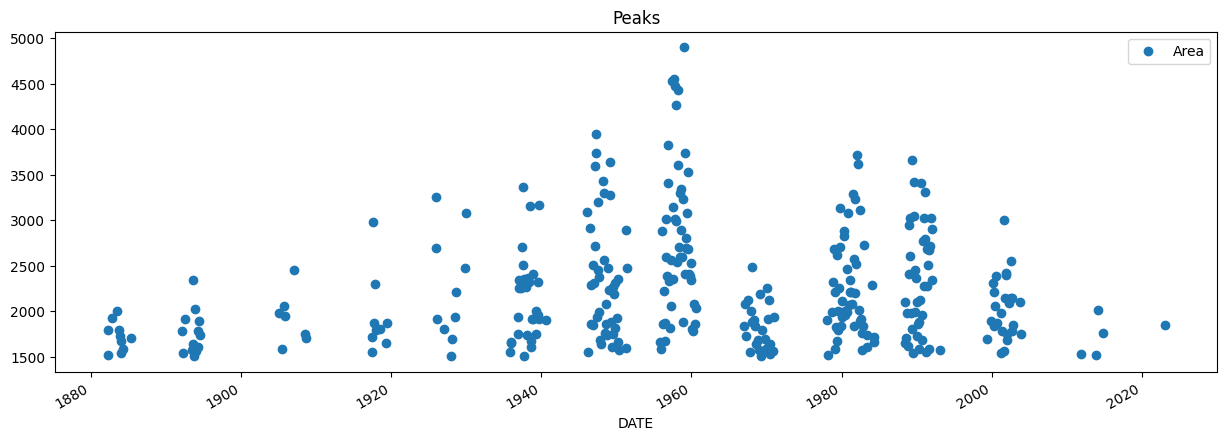

In [ ]:
data.query('Area > 1500')\
    .plot(style='o',
          figsize=(15, 5),
          title='Peaks')

In [ ]:
data.query('Area == 0')

,Area
DATE,
1878-08-01,0.0
1879-02-01,0.0
1879-03-01,0.0
1889-11-01,0.0
1900-12-01,0.0
1901-04-01,0.0
1901-08-01,0.0
1901-12-01,0.0
1902-04-01,0.0


In [ ]:
data.query('Area < 20')

,Area
DATE,
1876-04-01,15.8
1876-06-01,15.2
1877-07-01,4.2
1878-01-01,14.9
1878-02-01,18.1
...,...
2020-02-01,1.4
2020-03-01,1.4
2020-04-01,7.5


In [ ]:
a = data.query('Area < 1000')
b = data.query('Area < 20')
c = data.query('Area > 1000')
plt.figure(figsize=(20,5), dpi=1000)
plt.scatter(x=a.index, y=a, marker='.', label='middle values')
plt.scatter(x=c.index, y=c, marker='.', label='higher values')
plt.scatter(x=b.index, y=b, marker='.', edgecolors='black', label='nearly zero values')
plt.legend(['upper values', 'middle values','zero values'])
plt.show()

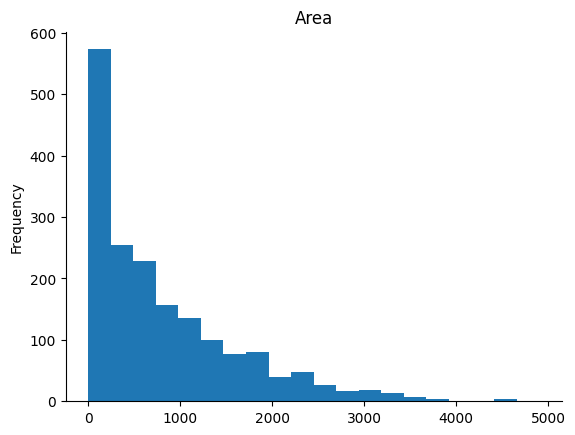

In [ ]:
data['Area'].plot(kind='hist', bins=20, title='Area')
plt.gca().spines[['top', 'right',]].set_visible(False)

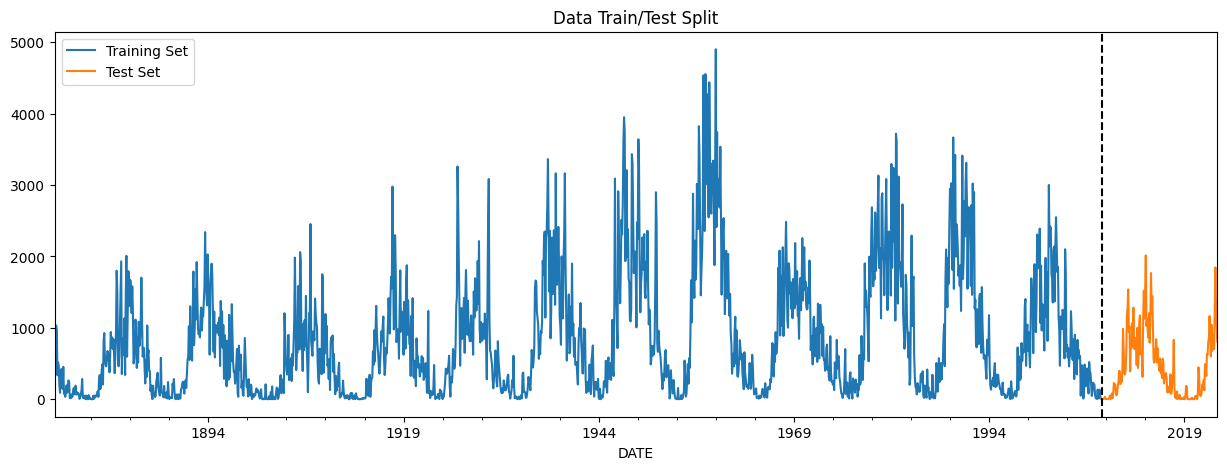

In [ ]:
train_scaled = data.loc[data.index < '2008-06-01']
test_scaled = data.loc[data.index >= '2008-06-01']
fig, ax = plt.subplots(figsize=(15, 5))
train_scaled.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_scaled.plot(ax=ax, label='Test Set')
ax.axvline('2008-06-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
train_scaled

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
2008-01-01,12.2
2008-02-01,11.1
2008-03-01,133.2


In [ ]:
def prepare_data(timeseries_data, n_steps):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        end_ix = i + n_steps
        if end_ix > len(timeseries_data)-1:
            break
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps=96
X,y=prepare_data(train_scaled['Area'],n_steps)
val_X,val_y=prepare_data(test_scaled['Area'],n_steps)

In [ ]:
X.shape

(1513, 96)

In [ ]:
val_X.shape

(83, 96)

In [ ]:
X

array([[ 365.1,  415.2, 1033.5, ...,  673.1,  928.9, 1799.1],
       [ 415.2, 1033.5,  954.1, ...,  928.9, 1799.1, 1519.6],
       [1033.5,  954.1,  335.3, ..., 1799.1, 1519.6,  557.8],
       ...,
       [2306.4, 1834. , 2216.1, ...,  135.9,   12.2,   11.1],
       [1834. , 2216.1, 2055.2, ...,   12.2,   11.1,  133.2],
       [2216.1, 2055.2, 2389.5, ...,   11.1,  133.2,   40.6]])

In [ ]:
from skopt.space import Real, Categorical, Integer

param_grid = {
    'boosting_type': ['gbdt', 'dart'],
    'n_estimators': Integer(50, 500),
    'learning_rate': Real(1e-4, 0.1),
    'max_depth': Integer(1, 10),
    'num_leaves': Integer(2, 1e+4),
    'random_state': Integer(1, 100),
    'colsample_bytree': Real(0.5, 1),
    'min_child_weight': Real(0.001, 1),
    'min_child_samples': Integer(10, 1000)
}

In [ ]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=5,
    max_train_size=1800,
    test_size=180,
)

In [ ]:
gbm_model = LGBMRegressor(objective='regression')

In [ ]:
import skopt
from skopt import BayesSearchCV
np.int = np.int64

bay_search = BayesSearchCV(estimator = gbm_model,
                    search_spaces = param_grid,
                    n_iter = 50,
                    cv = ts_cv,
                    scoring = 'neg_mean_squared_error')

bay_search.fit(X, y)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=1800, n_splits=5, test_size=180),
              estimator=LGBMRegressor(objective='regression'),
              scoring='neg_mean_squared_error',
              search_spaces={'boosting_type': ['gbdt', 'dart'],
                             'colsample_bytree': Real(low=0.5, high=1, prior='uniform', transform='normalize'),
                             'learning_rate': Real(low=0.0001, high=0.1, prior='uniform', tr...
                             'min_child_samples': Integer(low=10, high=1000, prior='uniform', transform='normalize'),
                             'min_child_weight': Real(low=0.001, high=1, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=50, high=500, prior='uniform', transform='normalize'),
                             'num_leaves': Integer(low=2, high=10000.0, prior='uniform', transform='normalize'),
                             'random_state': Integer(low=1, high=100, prior='uniform', transform='normalize')})

In [ ]:
print("val. score: %s" % bay_search.best_score_)
print("test score: %s" % bay_search.score(X, y))
print("best params: %s" % str(bay_search.best_params_))

val. score: -280936.1886224886
test score: -154833.99796412612
best params: OrderedDict([('boosting_type', 'gbdt'), ('colsample_bytree', 0.5), ('learning_rate', 0.04752256643090154), ('max_depth', 1), ('min_child_samples', 10), ('min_child_weight', 0.13959614650924204), ('n_estimators', 500), ('num_leaves', 2), ('random_state', 1)])


In [ ]:
best_params = bay_search.best_params_
best_model = bay_search.best_estimator_

In [ ]:
predictions = best_model.predict(val_X).reshape(-1,1)
predictions

array([[ 399.62670782],
       [ 245.06281686],
       [ 328.83894507],
       [ 350.67604152],
       [ 287.96468898],
       [ 301.99786452],
       [ 201.38801556],
       [ 187.89748354],
       [ 176.24662423],
       [ 149.10642262],
       [ 111.70363911],
       [ 256.84237645],
       [  96.19602041],
       [ 154.93986254],
       [ 120.07445359],
       [ 348.7491829 ],
       [ 455.23475649],
       [ 259.72497987],
       [ 240.68573305],
       [ 105.80344744],
       [ 105.7851708 ],
       [  95.60921609],
       [ 162.20840405],
       [  31.74502572],
       [  16.45885726],
       [  31.16153362],
       [   8.84686135],
       [  18.32761229],
       [  12.37028913],
       [  30.2872486 ],
       [   5.22996082],
       [   5.22996082],
       [   7.75997403],
       [  11.37687456],
       [  19.23836259],
       [ 120.16383636],
       [ 123.33773224],
       [  73.43668801],
       [  63.62755817],
       [  63.57990935],
       [  84.38508626],
       [  98.545

In [ ]:
RMSE = np.sqrt(MSE(predictions,val_y))
RMSE

190.80109459399102

In [ ]:
from sklearn.metrics import r2_score as R2
R2_score=R2(predictions,val_y)
R2_score

0.7376444214651697

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(predictions, val_y)
MAPE

0.8431821936673357

In [ ]:
train_predict = best_model.predict(X).reshape(-1,1)
test_predict = best_model.predict(val_X).reshape(-1,1)

In [ ]:
test = np.vstack((train_predict,test_predict))

In [ ]:
data_scaled1=data[96:]

In [ ]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(data_scaled1)))

In [ ]:
test=test.flatten()

In [ ]:
DF = pd.DataFrame()
DF['original'] = data_scaled1
DF = DF.set_index(date)

In [ ]:
DF1=pd.DataFrame()
DF1['predicted']=test
DF1 = DF1.set_index(date[:-96])

In [ ]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)
new.head()

,original,predicted
1882-05,1519.6,1250.706965
1882-06,557.8,1484.946889
1882-07,461.5,975.256584
1882-08,607.6,838.723372
1882-09,1026.9,872.865698


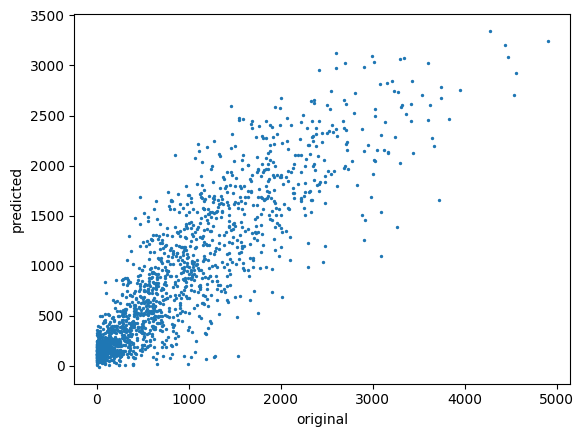

In [ ]:
from matplotlib import pyplot as plt
new.plot(kind='scatter', x='original', y='predicted', s=2, alpha=1)
plt.gca().spines[['top', 'right',]].set_visible(True)

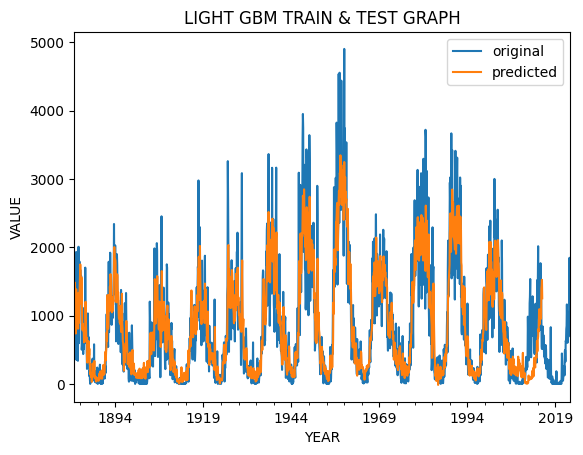

In [ ]:
new.plot()
plt.title('LIGHT GBM TRAIN & TEST GRAPH',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_train_test.png')

In [ ]:
len(test_predict),len(val_y)

(83, 83)

In [ ]:
len(data)

1788

In [ ]:
#data_n=data[:1759]

In [ ]:
#data_n

In [ ]:
import numpy as np

t_df = np.array(data).reshape(-1,1)

In [ ]:
len(t_df)

1788

In [ ]:
fut_inp = t_df[1692:]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

(1, 96)

In [ ]:
tmp_inp = tmp_inp[0].tolist()

In [ ]:
predictions

array([[ 399.62670782],
       [ 245.06281686],
       [ 328.83894507],
       [ 350.67604152],
       [ 287.96468898],
       [ 301.99786452],
       [ 201.38801556],
       [ 187.89748354],
       [ 176.24662423],
       [ 149.10642262],
       [ 111.70363911],
       [ 256.84237645],
       [  96.19602041],
       [ 154.93986254],
       [ 120.07445359],
       [ 348.7491829 ],
       [ 455.23475649],
       [ 259.72497987],
       [ 240.68573305],
       [ 105.80344744],
       [ 105.7851708 ],
       [  95.60921609],
       [ 162.20840405],
       [  31.74502572],
       [  16.45885726],
       [  31.16153362],
       [   8.84686135],
       [  18.32761229],
       [  12.37028913],
       [  30.2872486 ],
       [   5.22996082],
       [   5.22996082],
       [   7.75997403],
       [  11.37687456],
       [  19.23836259],
       [ 120.16383636],
       [ 123.33773224],
       [  73.43668801],
       [  63.62755817],
       [  63.57990935],
       [  84.38508626],
       [  98.545

In [ ]:
lst_output=[]
n_steps=96
i=0
while(i<120):

    if(len(tmp_inp)>96):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape(( 1,n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

lst_output

[[1333.5175667560013],
 [1711.6881100312498],
 [1489.7725513974433],
 [1694.7577700439995],
 [1700.7620833362275],
 [1670.5438049596291],
 [1833.0501843243428],
 [1722.1451214864267],
 [1817.3748673470495],
 [1812.4932128835987],
 [1716.3683544966416],
 [1759.1418057691253],
 [1847.7337730276122],
 [1776.4639934541167],
 [1861.6082300228181],
 [1711.5650480093464],
 [1606.710425539858],
 [1864.26229924699],
 [1788.4277014235572],
 [1669.7384655423457],
 [1889.7923313255428],
 [1684.1934212830618],
 [1671.4351479099807],
 [1759.0656649234083],
 [1797.6262744955898],
 [1711.7764449304511],
 [1712.8630355923335],
 [1849.1995738940695],
 [1811.1168143859188],
 [1550.8136100867616],
 [1678.1733359703157],
 [1652.4895490453796],
 [1654.491461337828],
 [1699.335440897513],
 [1622.9803153883058],
 [1570.8364503845921],
 [1495.9172320988405],
 [1564.162217107088],
 [1536.6972711560989],
 [1521.0365171567032],
 [1481.4948213736056],
 [1480.6952201362328],
 [1481.4948213736056],
 [1470.0704215278

In [ ]:
n_steps=96

X1,y1=prepare_data(t_df,n_steps)

In [ ]:
X1.shape

(1692, 96, 1)

In [ ]:
X1 = np.array([X1]).reshape(1692, 96)

In [ ]:
train_p=best_model.predict(X1).reshape(-1,1)

In [ ]:
type(train_p)

numpy.ndarray

In [ ]:
test = np.vstack((train_p,lst_output))

In [ ]:
test=test.flatten()

In [ ]:
data_n = np.array(data).reshape(-1,1)

In [ ]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(data_scaled1)+120))

In [ ]:
DF = pd.DataFrame()
DF['original'] = data_scaled1
DF = DF.set_index(date[:-120])

In [ ]:
DF1=pd.DataFrame()
DF1['predicted']=test
DF1 = DF1.set_index(date)

In [ ]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)
new

,original,predicted
1882-05,1519.6,1250.706965
1882-06,557.8,1484.946889
1882-07,461.5,975.256584
1882-08,607.6,838.723372
1882-09,1026.9,872.865698
...,...,...
2032-12,NaN,1609.975671
2033-01,NaN,1609.975671
2033-02,NaN,1609.975671
2033-03,NaN,1609.975671


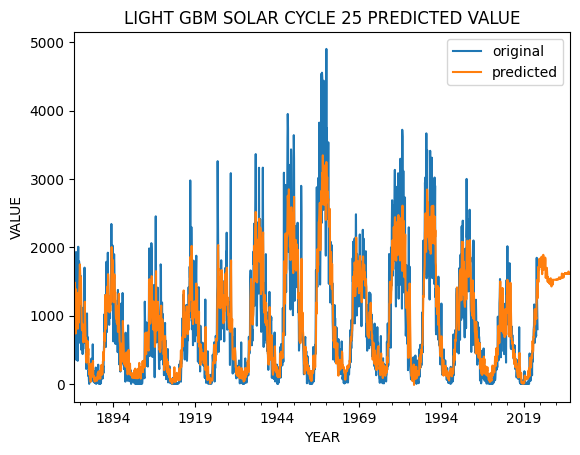

In [ ]:
new.plot()
plt.title('LIGHT GBM SOLAR CYCLE 25 PREDICTED VALUE',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_predict.png')

In [ ]:
print("Largest element is:", max(lst_output))

Largest element is: [1889.7923313255428]


In [ ]:
i=max(lst_output)
time=int(np.where(np.array(lst_output) == i)[0])
time

<ipython-input-535-75ffc8ac41e8>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time=int(np.where(np.array(lst_output) == i)[0])


20

In [ ]:
new_date = np.datetime64('2023-05') + np.timedelta64(time, 'M')
print('Peak month is : '+str(new_date))


Peak month is : 2025-01


In [ ]:
new.query('predicted <= 0')

,original,predicted
1985-09,19.1,-13.697044


In [ ]:
output = np.array(lst_output)
output.flatten()

array([1333.51756676, 1711.68811003, 1489.7725514 , 1694.75777004,
       1700.76208334, 1670.54380496, 1833.05018432, 1722.14512149,
       1817.37486735, 1812.49321288, 1716.3683545 , 1759.14180577,
       1847.73377303, 1776.46399345, 1861.60823002, 1711.56504801,
       1606.71042554, 1864.26229925, 1788.42770142, 1669.73846554,
       1889.79233133, 1684.19342128, 1671.43514791, 1759.06566492,
       1797.6262745 , 1711.77644493, 1712.86303559, 1849.19957389,
       1811.11681439, 1550.81361009, 1678.17333597, 1652.48954905,
       1654.49146134, 1699.3354409 , 1622.98031539, 1570.83645038,
       1495.9172321 , 1564.16221711, 1536.69727116, 1521.03651716,
       1481.49482137, 1480.69522014, 1481.49482137, 1470.07042153,
       1461.30764058, 1515.64129832, 1542.62481595, 1546.83892474,
       1500.00278969, 1448.0486416 , 1426.92953097, 1456.86189914,
       1524.81714481, 1524.81714481, 1493.98363802, 1455.23148509,
       1524.81714481, 1524.81714481, 1524.81714481, 1524.81714

In [ ]:
len(output)

120

In [ ]:
train_d = np.array(data['Area'])
train_d.flatten()

array([ 365.1,  415.2, 1033.5, ..., 1278.5, 1013.2,  802. ])

In [ ]:
n_data = np.append(train_d, output)

In [ ]:
n_data.shape

(1908,)

In [ ]:
DATE = pd.Series(pd.period_range("1874-05-01", freq="M", periods=len(n_data)))

In [ ]:
new_d = pd.DataFrame()
new_d['Area'] = n_data
new_d = new_d.set_index(DATE)

In [ ]:
new_d.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1908 entries, 1874-05 to 2033-04
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    1908 non-null   float64
dtypes: float64(1)
memory usage: 29.8 KB


In [ ]:
new_d

,Area
1874-05,365.100000
1874-06,415.200000
1874-07,1033.500000
1874-08,954.100000
1874-09,335.300000
...,...
2032-12,1609.975671
2033-01,1609.975671
2033-02,1609.975671
2033-03,1609.975671


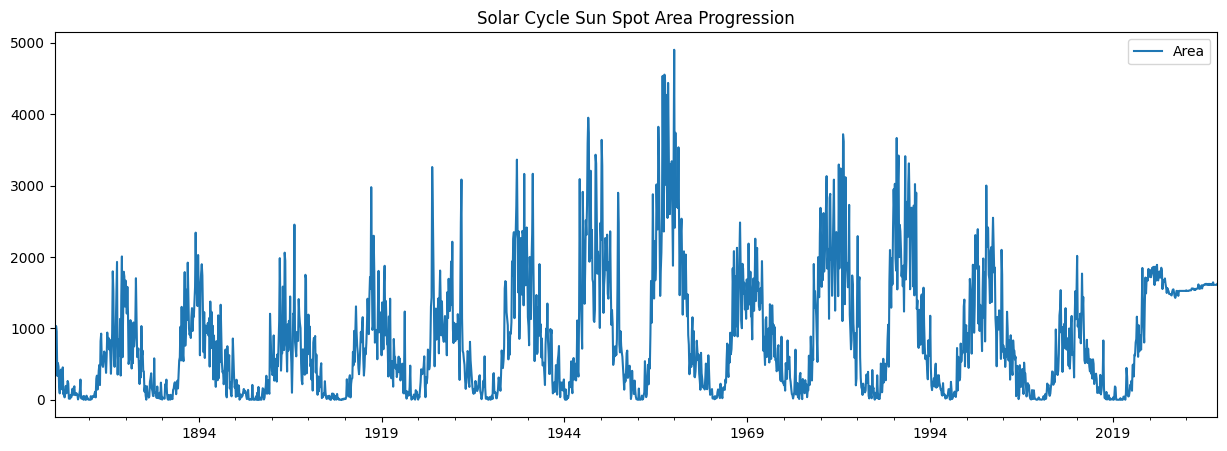

In [ ]:
new_d.plot(style='-',
        figsize=(15, 5),
        title='Solar Cycle Sun Spot Area Progression')
plt.show()

In [ ]:
new_d.query('Area < 10')

,Area
1877-07,4.2
1878-04,0.4
1878-07,0.4
1878-08,0.0
1878-10,9.6
...,...
2020-02,1.4
2020-03,1.4
2020-04,7.5
2020-05,1.8


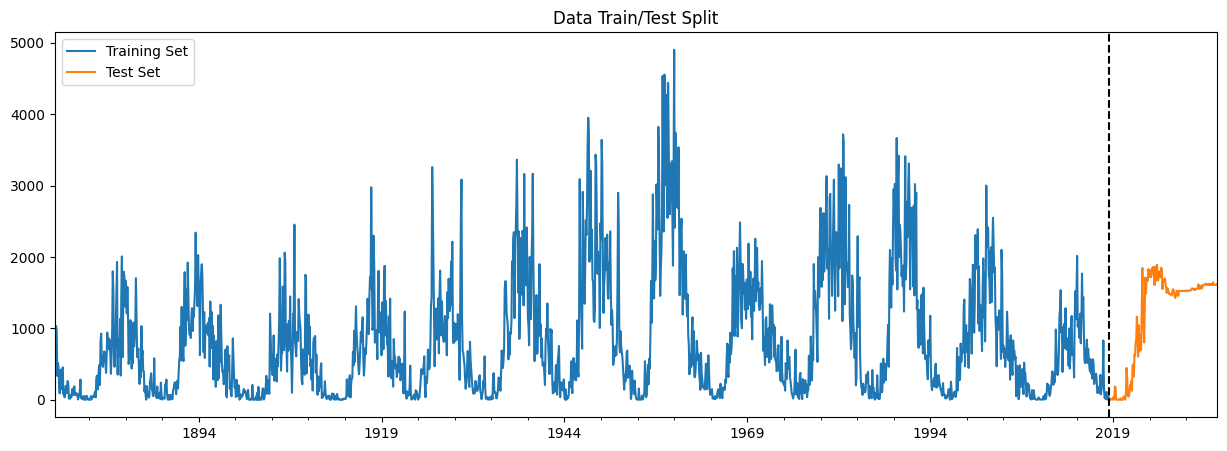

In [ ]:
train_d = new_d.loc[new_d.index < '2018-07-01']
test_d = new_d.loc[new_d.index >= '2018-07-01']
fig, ax = plt.subplots(figsize=(15, 5))
train_d.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_d.plot(ax=ax, label='Test Set')
ax.axvline('2018-07-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
test_d

,Area
2018-07,0.500000
2018-08,21.200000
2018-09,1.900000
2018-10,7.700000
2018-11,11.200000
...,...
2032-12,1609.975671
2033-01,1609.975671
2033-02,1609.975671
2033-03,1609.975671


In [ ]:
n_steps=96
Xd,yd=prepare_data(train_d['Area'],n_steps)
val_Xd,val_yd=prepare_data(test_d['Area'],n_steps)

In [ ]:
Xd.shape

(1634, 96)

In [ ]:
val_Xd.shape

(82, 96)

In [ ]:
Xd

array([[ 365.1,  415.2, 1033.5, ...,  673.1,  928.9, 1799.1],
       [ 415.2, 1033.5,  954.1, ...,  928.9, 1799.1, 1519.6],
       [1033.5,  954.1,  335.3, ..., 1799.1, 1519.6,  557.8],
       ...,
       [  85.4,   54.9,   85.9, ...,    8.6,  109.5,    2.7],
       [  54.9,   85.9,  182.5, ...,  109.5,    2.7,   28. ],
       [  85.9,  182.5,  234.4, ...,    2.7,   28. ,   33.9]])

In [ ]:
ts_cv2 = TimeSeriesSplit(
    n_splits=5,
    gap=5,
    max_train_size=1920,
    test_size=178,
)

In [ ]:
import skopt
from skopt import BayesSearchCV
np.int = np.int64

bay_search = BayesSearchCV(estimator = gbm_model,
                    search_spaces = param_grid,
                    n_iter = 60,
                    cv = ts_cv2,
                    scoring = 'neg_mean_squared_error')

bay_search.fit(Xd, yd)

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

Exception ignored on calling ctypes callback function: <function _log_callback at 0x784000b953f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 205, in _log_callback
    _log_native(str(msg.decode('utf-8')))
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 183, in wrapper
    return func(msg)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 200, in _log_native
    getattr(_LOGGER, _INFO_METHOD_NAME)(msg)
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 133, in info
    print(msg)  # noqa: T201
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 402, in write
    self.pub_thread.schedule(lambda : self._buffer.write(string))
  File "/usr/local/lib/python3.10/dist-packages/ipykernel/iostream.py", line 203, in schedule
    self._event_pipe.send(b'')
  File "/usr/local/lib/python3.10/dist-packages/zmq/sugar/socket.py", line 618, in se

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x784000b953f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 203, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

Exception ignored on calling ctypes callback function: <function _log_callback at 0x784000b953f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 203, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

Exception ignored on calling ctypes callback function: <function _log_callback at 0x784000b953f0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py", line 203, in _log_callback
    def _log_callback(msg: bytes) -> None:
KeyboardInterrupt: 


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with po

In [ ]:
print("val. score: %s" % bay_search.best_score_)
print("test score: %s" % bay_search.score(Xd, yd))
print("best params: %s" % str(bay_search.best_params_))

In [ ]:
best_params = bay_search.best_params_
best_model = bay_search.best_estimator_

In [ ]:
predictions2 = best_model.predict(val_Xd).reshape(-1,1)
predictions2

In [ ]:
RMSE = np.sqrt(MSE(predictions2,val_yd))
RMSE

In [ ]:
from sklearn.metrics import r2_score as R2
R2_score=R2(predictions2,val_yd)
R2_score

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(predictions2, val_yd)
MAPE

In [ ]:
train_pred = best_model.predict(Xd).reshape(-1,1)
test_pred = best_model.predict(val_Xd).reshape(-1,1)

In [ ]:
test2 = np.vstack((train_pred,test_pred))

In [ ]:
test2=test2.flatten()

In [ ]:
test2.shape

In [ ]:
new_d1 = new_d[96:]
new_d1.shape

In [ ]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(new_d1)))

In [ ]:
DF = pd.DataFrame()
DF['original'] = new_d1
DF = DF.set_index(date)

In [ ]:
DF1=pd.DataFrame()
DF1['predicted']=test2
DF1 = DF1.set_index(date[:-96])

In [ ]:
new2 = pd.concat([DF, DF1], ignore_index=False, axis=1)
new2.head()

In [ ]:
from matplotlib import pyplot as plt
new2.plot(kind='scatter', x='original', y='predicted', s=2, alpha=1)
plt.gca().spines[['top', 'right',]].set_visible(True)

In [ ]:
new2.plot()
plt.title('LIGHT GBM TRAIN & TEST GRAPH',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_train_test.png')

In [ ]:
len(test_pred),len(val_yd)

In [ ]:
len(new_d1)

In [ ]:
new_d.query('Area < 10')

In [ ]:
import numpy as np

t_df = np.array(new_d).reshape(-1,1)

In [ ]:
len(t_df)

In [ ]:
fut_inp = t_df[1812:]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

In [ ]:
tmp_inp = tmp_inp[0].tolist()

In [ ]:
predictions2

In [ ]:
lst_output=[]
n_steps=96
i=0
while(i<120):

    if(len(tmp_inp)>96):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape(( 1,n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

lst_output

In [ ]:
n_steps=96

X1,y1=prepare_data(t_df,n_steps)

In [ ]:
X1.shape

In [ ]:
X1 = np.array([X1]).reshape(1812, 96)

In [ ]:
train_p=best_model.predict(X1).reshape(-1,1)

In [ ]:
type(train_p)

In [ ]:
test_2 = np.vstack((train_p,lst_output))

In [ ]:
test_2=test_2.flatten()

In [ ]:
data_n = np.array(data_n).reshape(-1,1)

In [ ]:
data_s2 = data_n[96:]

In [ ]:
test_2.shape

In [ ]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(new_d1)+120))

In [ ]:
DF = pd.DataFrame()
DF['original'] = new_d1
DF = DF.set_index(date[:-120])

In [ ]:
DF1=pd.DataFrame()
DF1['predicted']=test_2
DF1 = DF1.set_index(date)

In [ ]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)
new

In [ ]:
new.plot()
plt.title('LIGHT GBM SOLAR CYCLE 26 PREDICTED VALUE',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_predict.png')

In [ ]:
print("Largest element is:", max(lst_output))

In [ ]:
i=max(lst_output)
time=int(np.where(np.array(lst_output) == i)[0])
time

In [ ]:
new_date = np.datetime64('2033-05') + np.timedelta64(time, 'M')
print('Peak month is : '+str(new_date))


In [ ]:
new.query('predicted <= 0')